# Project 4: West Nile Virus

---
#### 03. Modelling

# Table of Contents

- Import Libraries and Data
- Preprocessing
- Modelling
- Evaluating and Interpreting Results
- Generating Predictions for Kaggle
---
7 different models are tested & evaluated and the metric used for scoring is ROC-AUC.

# Import Libraries and Data

In [48]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from imblearn.over_sampling import SMOTE

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)

In [2]:
# import training dataset
train = pd.read_csv("../output_data/merged_train.csv")

# data cleaning
train.set_index("date", inplace=True)

# check the df columns
print(f"Features in training set : {train.columns.tolist()}")

Features in training set : ['species', 'latitude', 'longitude', 'wnvpresent', 'tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool', 'preciptotal', 'temp_fluct', 'daylight', 'relative_hum', 'tavg_weekly', 'relative_hum_weekly', 'preciptotal_weekly', 'tavg_weekly_lag1', 'tavg_weekly_lag2', 'relative_hum_weekly_lag1', 'relative_hum_weekly_lag2', 'preciptotal_weekly_lag1', 'preciptotal_weekly_lag2']


In [3]:
# define feature matrix and target vector
X = train.drop(columns="wnvpresent")
y = train["wnvpresent"]

# Preprocessing 
## Train-validation  split

The data is split into train & validation sets. Stratify = y was used because the dataset is highly imbalanced with a large majority of the target being 0, so stratifying generates better prediction results.

In [4]:
# split dataset into train and validation set
X_train, X_val, y_train, y_val = train_test_split(
    X, y, random_state=42, stratify=y
)

In [5]:
# check the shape of training and testing vectors
print(" Train Set Shape ".center(27, "="))
print(f"Features X_train: {X_train.shape}")
print(f"Targets y_train:  {y_train.shape}")
print()
print(" Validation Set Shape ".center(26, "="))
print(f"Features X_val:   {X_val.shape}")
print(f"Targets y_val:    {y_val.shape}")

===== Train Set Shape =====
Features X_train: (7879, 24)
Targets y_train:  (7879,)

== Validation Set Shape ==
Features X_val:   (2627, 24)
Targets y_val:    (2627,)


## Features transformation 

One Hot Encoder was used for categorical features such as Mosquito Species, as explained on the EDA/ Feature Engineering notebook. Numerical features are transformed using StandardScaler to ensure that they have the same range, which is important for certain classifiers like Logistic Regression.

In [6]:
# instantiate transformers
ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")
sc = StandardScaler()


# instantiate transformers into column transformer
ct = make_column_transformer(
    (sc, make_column_selector(dtype_include="number")),
    (ohe, make_column_selector(dtype_exclude="number")),
    remainder="passthrough",
    verbose_feature_names_out=False,
)

# transform feature matrix
X_train = pd.DataFrame(
    ct.fit_transform(X_train), columns=ct.get_feature_names_out()
)

X_val = pd.DataFrame(ct.transform(X_val), columns=ct.get_feature_names_out())

# check X matrix after transformation
X_train.head()

,latitude,longitude,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,relative_hum_weekly_lag2,preciptotal_weekly_lag1,preciptotal_weekly_lag2,species_ERRATICUS,species_PIPIENS,species_PIPIENS/RESTUANS,species_RESTUANS,species_SALINARIUS,species_TARSALIS,species_TERRITANS
0,0.627512,-0.279292,0.074525,-0.149319,-0.065976,0.660970,-0.148577,-0.118680,-0.330573,-0.241910,...,0.890670,-0.718824,-0.185112,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.351569,-0.658353,-1.856803,-2.343141,-2.202696,-1.646831,-2.182258,-2.268127,2.814834,-1.549664,...,0.890670,-0.718824,-0.185112,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.185404,-1.972897,-2.822467,-2.210182,-2.670104,-2.262245,-2.627126,-2.638722,4.110001,-1.549664,...,0.890670,-0.718824,-0.185112,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.035515,-2.390206,-0.408307,-0.016360,-0.266293,-0.877564,-1.610285,-1.008107,-0.330573,-0.503461,...,-1.930212,-0.103824,-1.033891,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.185404,-1.972897,-1.675741,-1.412429,-1.668516,-1.339124,-1.928048,-1.897533,1.334643,-1.549664,...,0.222000,-0.799921,0.096492,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [7]:
# check the df cloumns
print(f"Features in X matrix: {X_train.columns.tolist()}")

Features in X matrix: ['latitude', 'longitude', 'tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool', 'preciptotal', 'temp_fluct', 'daylight', 'relative_hum', 'tavg_weekly', 'relative_hum_weekly', 'preciptotal_weekly', 'tavg_weekly_lag1', 'tavg_weekly_lag2', 'relative_hum_weekly_lag1', 'relative_hum_weekly_lag2', 'preciptotal_weekly_lag1', 'preciptotal_weekly_lag2', 'species_ERRATICUS', 'species_PIPIENS', 'species_PIPIENS/RESTUANS', 'species_RESTUANS', 'species_SALINARIUS', 'species_TARSALIS', 'species_TERRITANS']


In [8]:
# check the shape of training and testing vectors
print(" Train Set Shape ".center(27, "="))
print(f"Features X_train: {X_train.shape}")
print(f"Targets y_train:  {y_train.shape}")
print()
print(" Validation Set Shape ".center(26, "="))
print(f"Features X_val:   {X_val.shape}")
print(f"Targets y_val:    {y_val.shape}")

===== Train Set Shape =====
Features X_train: (7879, 30)
Targets y_train:  (7879,)

== Validation Set Shape ==
Features X_val:   (2627, 30)
Targets y_val:    (2627,)


We confirm that the train & validation set shapes are similar and proceed to the modelling section.

# Modelling


In this section, we define a modelling and scoring function, as well as run the following models:

- Dummy Classifier
- Random Forest Classifier
- Support Vector Classifier
- Logistic Regression
- K Nearest Neighbors
- Gradient Boosting Classifier
- XGBoost Classifier
- Extra Trees Classifier

## Functions used

Two functions are defined here. Fit_gs fits a GridSearchCV to a classifier, prints best parameters and scores, and returns model. Eval_model returns a dataframe of scoring & evaluation metrics.

In [9]:
def fit_gs(clf, params):
    """fits a GridSearchCV to a classifier, prints best params and scores, and returns model"""

    gs = GridSearchCV(clf, params, cv=5, n_jobs=-1, scoring="roc_auc")
    gs.fit(X_train, y_train)
    print(" GridSearchCV ".center(45, "="))
    print(f"Best Parameters: {gs.best_params_}")
    print(f"Best Score (ROC AUC): {gs.best_score_}")
    print()
    print(" Evaluation ".center(45, "="))
    print(
        f"Train Score (ROC AUC): {roc_auc_score(y_train, gs.predict_proba(X_train)[:,1])}"
    )
    print(
        f"Testing Score (ROC AUC): {roc_auc_score(y_val,gs.predict_proba(X_val)[:,1])}"
    )

    return gs

In [10]:
def eval_model(model):
    """returns dataframe of evaluation metrics for classifier"""

    # get predictions
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    # metrics for evaluating classifier
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

    accuracy = (tn + tp) / (tn + fp + fn + tp)

    if (tn + fp) != 0:
        spec = tn / (tn + fp)
    else:
        spec = "NA"

    if (tp + fn) != 0:
        recall = tp / (tp + fn)
    else:
        recall = np.nan

    if (tp + fp) != 0:
        precision = tp / (tp + fp)
    else:
        precision = np.nan

    if recall == np.nan or precision == np.nan:
        f1 = np.nan
    else:
        f1 = 2 * ((precision * recall) / (precision + recall))

    roc = roc_auc_score(y_val, y_proba)

    try:
        model_name = str(model.estimator)[:-2]
        if len(model_name) > 30:
            model_name = model_name[:13]
    except:
        model_name = "Dummy"

    df = pd.DataFrame(
        [np.round([accuracy, spec, recall, precision, f1, fp, fn, roc], 3)],
        columns=[
            "Accuracy",
            "Specificity",
            "Recall",
            "Precision",
            "F1",
            "False Positives",
            "False Negatives",
            "ROC-AUC",
        ],
        index=[model_name],
        dtype="str",
    )
    return df

## (0) Dummy Model

The dummy model is used as the baseline model, which is the simplest possible prediction of a model. Because this is an imbalanced classification problem with majority of the data being 0, the dummy classifier predicts all rows as 0, produces a high specificity (1.0) with a 0 recall (0.0) and a ROC-AUC of 0.5, which will be used as the baseline for comparison with relatively more complex models.

In [11]:
# fit dummy model
dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(X_train, y_train)

dummy_result = eval_model(dummy)
dummy_result

,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
Dummy,0.947,1.0,0.0,NaN,NaN,0.0,138.0,0.5


## (1) Random Forest Classifier

Random Forest has its advantages in this classification problem because it is non-parameteric and makes no underlying assumptions of the data distribution. However, it has a tendency to overfit onto training & validation data and underperform on the test set (the Kaggle dataset).

This classifier has one of the lowest performing model accuracy but its ROC-AUC score is decent and comparable to other models. It also has the lowest false negative rate, which is beneficial because false negatives are more dangerous than false positives in this problem set. It is worse to leave a WNV-positive mosquito undetected than to falsely predict a WNV-negative mosquito as WNV-positive.

In [12]:
rfc_params = {
    "n_estimators": [100, 150, 200],
    "max_depth": [5, 8, 15],
    "class_weight": [None, "balanced", "balanced_subsample"],
    "random_state": [42],
}

rfc = fit_gs(RandomForestClassifier(), rfc_params)

================ GridSearchCV ===============
Best Parameters: {'class_weight': 'balanced_subsample', 'max_depth': 8, 'n_estimators': 150, 'random_state': 42}
Best Score (ROC AUC): 0.8397458112062054

================= Evaluation ================
Train Score (ROC AUC): 0.9111562408179388
Testing Score (ROC AUC): 0.8215219429256846


In [13]:
rfc_result = eval_model(rfc)
rfc_result

,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
RandomForestClassifier,0.774,0.777,0.703,0.149,0.246,554.0,41.0,0.822


## (2) Support Vector Classifier

SVC performs comparably to the Random Forest Classifier, with a relatively low accuracy due to the large number of false positives and a slightly larger number of false negatives compared to Random Forest. The overfit is less pronounced than Random Forest as the difference between the Train Score and Test Score is not as large.

In [14]:
svc_params = {
    "C": [10 ** -2, 10 ** -1, 10 ** 0, 10 ** 1, 10 ** 2],
    "class_weight": [None, {0: 1, 1: 10}, {0: 1, 1: 25}],
    "probability": [True],
    "random_state": [42],
}
svc = fit_gs(SVC(), svc_params)

================ GridSearchCV ===============
Best Parameters: {'C': 1, 'class_weight': {0: 1, 1: 10}, 'probability': True, 'random_state': 42}
Best Score (ROC AUC): 0.8181143378889143

================= Evaluation ================
Train Score (ROC AUC): 0.8834409289829795
Testing Score (ROC AUC): 0.815328023011395


In [15]:
svc_result = eval_model(svc)
svc_result

,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
SVC,0.809,0.818,0.63,0.161,0.257,452.0,51.0,0.815


## (3) Logistic Regression

The best penalty is L1 (Lasso) rather than L2 (Ridge), which implies that some features are given a weight of 0 during the modelling process. The C of 1 suggests a moderate level of regularization.

The benefit of using Logistic Regression is the interpretability of coefficients. However, because it predicts all rows as 0 like the Dummy Classifier, it yields little benefit to our classification task.

In [16]:
lr_params = {
    "C": [10 ** -2, 10 ** -1, 10 ** 0, 10 ** 1, 10 ** 2],
    "penalty": ["l1", "l2"],
    "max_iter": [20, 50, 100, 200],
    "class_weight": [None, {0: 1, 1: 10}, {0: 1, 1: 25}],
    "solver": ["liblinear"],
    "random_state": [42],
}

lr = fit_gs(LogisticRegression(), lr_params)

================ GridSearchCV ===============
Best Parameters: {'C': 100, 'class_weight': None, 'max_iter': 20, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear'}
Best Score (ROC AUC): 0.809037749241347

================= Evaluation ================
Train Score (ROC AUC): 0.8196664264601625
Testing Score (ROC AUC): 0.7686327085553246


In [17]:
lr_result = eval_model(lr)
lr_result

,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
LogisticRegression,0.947,1.0,0.0,NaN,NaN,0.0,138.0,0.769


## (4) K-nearest neighbours

K Nearest Neighbors produced very similar results to Logistic Regression, predicting all rows as 0 like the Dummy Classifier.

In [18]:
knn_params = {"n_neighbors": [5, 35, 65, 95]}

knn = fit_gs(KNeighborsClassifier(), knn_params)

================ GridSearchCV ===============
Best Parameters: {'n_neighbors': 65}
Best Score (ROC AUC): 0.8129837156936439

================= Evaluation ================
Train Score (ROC AUC): 0.8601425736948582
Testing Score (ROC AUC): 0.7928566853576025


In [19]:
knn_result = eval_model(knn)
knn_result

,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
KNeighborsClassifier,0.947,1.0,0.0,NaN,NaN,0.0,138.0,0.793


## (5) Gradient boosting classifier

Gradient Boosting Classifier has the highest ROC-AUC score among all the models and will be selected as the production model.

In [20]:
gbc_params = {
    "n_estimators": [150, 200, 250],
    "max_depth": [3, 5],
    "random_state": [42],
}
gbc = fit_gs(GradientBoostingClassifier(), gbc_params)

================ GridSearchCV ===============
Best Parameters: {'max_depth': 3, 'n_estimators': 200, 'random_state': 42}
Best Score (ROC AUC): 0.8397836522769234

================= Evaluation ================
Train Score (ROC AUC): 0.9218337009941435
Testing Score (ROC AUC): 0.8257099353095649


In [21]:
gbc_result = eval_model(gbc)
gbc_result

,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
GradientBoostingClassifier,0.944,0.992,0.08,0.367,0.131,19.0,127.0,0.826


## (6) XGB classifier

XGB classifier is widely regarded as the best performing classifier. However, it has a very high computational cost. Disappointingly, it did not yield better ROC-AUC scores than Gradient Boost Classifier, although it had the best accuracy score among all of the models.

In [22]:
xgb_params = {
    "use_label_encoder": [False],
    "objective": ["binary:logistic"],
    "eval_metric": ["auc"],
    "learning_rate": [0.2, 0.5],
    "max_depth": [5, 8],
    "gamma": np.linspace(5, 100, 8),
    "reg_alpha": np.linspace(0.0001, 1, 8),
    "reg_lambda": np.linspace(5, 100, 5),
}

xgb = fit_gs(XGBClassifier(random_state=42), xgb_params)

================ GridSearchCV ===============
Best Parameters: {'eval_metric': 'auc', 'gamma': 5.0, 'learning_rate': 0.5, 'max_depth': 8, 'objective': 'binary:logistic', 'reg_alpha': 0.0001, 'reg_lambda': 5.0, 'use_label_encoder': False}
Best Score (ROC AUC): 0.8372151072502099

================= Evaluation ================
Train Score (ROC AUC): 0.8853840396074797
Testing Score (ROC AUC): 0.8128242527992734


In [23]:
xgb_result = eval_model(xgb)
xgb_result

,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
XGBClassifier,0.946,0.996,0.029,0.308,0.053,9.0,134.0,0.813


## (7) Extra trees classifier

Extra trees produced very similar results to Logistic Regression and K Nearest Neighbors, predicting all rows as 0 like the Dummy Classifier.

In [24]:
et_params = {
    "max_depth": [3, 5, 10, 20],
    "min_samples_leaf": [1, 3, 10, 20],
    "max_leaf_nodes": [None, 5, 10],
    "random_state": [42],
}
et = fit_gs(ExtraTreesClassifier(), et_params)

================ GridSearchCV ===============
Best Parameters: {'max_depth': 10, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'random_state': 42}
Best Score (ROC AUC): 0.8304832194235805

================= Evaluation ================
Train Score (ROC AUC): 0.9324130570288293
Testing Score (ROC AUC): 0.8142653763515992


In [25]:
et_result = eval_model(et)
et_result

,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
ExtraTreesClassifier,0.947,1.0,0.0,NaN,NaN,0.0,138.0,0.814


# Modelling with oversampling 

In this section, due to the class imbalance, we applied oversampling on the training set using SMOTE.

In [26]:
# instantiate smote
sm = SMOTE()

# apply oversampling
X_train, y_train = sm.fit_resample(X_train, y_train)

In [27]:
# verify the distribution of classes
y_train.value_counts(normalize=True)

1    0.5
0    0.5
Name: wnvpresent, dtype: float64

## (0) Dummy Model with Oversampling

In [28]:
# fit dummy model
dummy_os = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_os.fit(X_train, y_train)

dummy_os_result = eval_model(dummy_os)
dummy_os_result

,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
Dummy,0.947,1.0,0.0,NaN,NaN,0.0,138.0,0.5


## (1) Random Forest Classifier with Oversampling
There is a large amount of overfit of almost 0.2 difference between Train Score and Test Score. This model is unlikely to produce good results on unseen data.

In [29]:
rfc_params = {
    "n_estimators": [10, 50, 100, 250],
    "max_depth": [5, 10, 20],
    "class_weight": [None, "balanced", "balanced_subsample"],
    "random_state": [42],
}
rfc_os = fit_gs(RandomForestClassifier(), rfc_params)

================ GridSearchCV ===============
Best Parameters: {'class_weight': None, 'max_depth': 20, 'n_estimators': 250, 'random_state': 42}
Best Score (ROC AUC): 0.9775672297124437

================= Evaluation ================
Train Score (ROC AUC): 0.9973312806788577
Testing Score (ROC AUC): 0.8039431469480205


In [30]:
rfc_os_result = eval_model(rfc_os)
rfc_os_result

,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
RandomForestClassifier,0.887,0.917,0.341,0.185,0.24,207.0,91.0,0.804


## (2) Support Vector Classifier with Oversampling
Like Random Forest, the overfit here is also very large at over 0.15 difference between the Train Score and Test Score.

In [31]:
svc_params = {
    "C": [10 ** -2, 10 ** -1, 10 ** 0, 10 ** 1, 10 ** 2],
    "class_weight": [None, {0: 1, 1: 10}, {0: 1, 1: 25}],
    "probability": [True],
    "random_state": [42],
}
svc_os = fit_gs(SVC(), svc_params)

================ GridSearchCV ===============
Best Parameters: {'C': 100, 'class_weight': None, 'probability': True, 'random_state': 42}
Best Score (ROC AUC): 0.9501073414465285

================= Evaluation ================
Train Score (ROC AUC): 0.9584480540733673
Testing Score (ROC AUC): 0.804103271787168


In [32]:
svc_os_result = eval_model(svc_os)
svc_os_result

,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
SVC,0.83,0.844,0.58,0.171,0.264,388.0,58.0,0.804


## (3) Logistic Regression with Oversampling
Although the overfit is less here, this model has a low accuracy due to the very large number of false positives.

In [33]:
lr_params = {
    "C": [10 ** -2, 10 ** -1, 10 ** 0, 10 ** 1, 10 ** 2],
    "penalty": ["l1", "l2"],
    "max_iter": [20, 50, 100, 200],
    "class_weight": [None, {0: 1, 1: 10}, {0: 1, 1: 25}],
    "solver": ["liblinear"],
    "random_state": [42],
}

lr_os = fit_gs(LogisticRegression(), lr_params)

================ GridSearchCV ===============
Best Parameters: {'C': 10, 'class_weight': None, 'max_iter': 20, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear'}
Best Score (ROC AUC): 0.8248646421964224

================= Evaluation ================
Train Score (ROC AUC): 0.8259697018124273
Testing Score (ROC AUC): 0.7764919267967463


In [34]:
lr_os_result = eval_model(lr_os)
lr_os_result

,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
LogisticRegression,0.679,0.675,0.768,0.116,0.201,810.0,32.0,0.776


## (4) K-nearest neighbours with Oversampling
The overfit is very large at more than 0.15 difference between Train Score and Test Score.

In [35]:
knn_params = {"n_neighbors": [5, 35, 65, 95]}

knn_os = fit_gs(KNeighborsClassifier(), knn_params)

================ GridSearchCV ===============
Best Parameters: {'n_neighbors': 5}
Best Score (ROC AUC): 0.9517869305503643

================= Evaluation ================
Train Score (ROC AUC): 0.98584707321104
Testing Score (ROC AUC): 0.7213274640301384


In [36]:
knn_os_result = eval_model(knn_os)
knn_os_result

,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
KNeighborsClassifier,0.835,0.861,0.377,0.13,0.194,347.0,86.0,0.721


## (5) Gradient boosting classifier with Oversampling
The ROC-AUC score is marginally better than the same classifier without oversampling. However, the model overtrained on the train data with a very high Train Score of 0.994, and may not perform as well with unseen data.

In [37]:
gbc_params = {
    "n_estimators": [150, 200, 250],
    "max_depth": [3, 5],
    "random_state": [42],
}
gbc_os = fit_gs(GradientBoostingClassifier(), gbc_params)

================ GridSearchCV ===============
Best Parameters: {'max_depth': 5, 'n_estimators': 250, 'random_state': 42}
Best Score (ROC AUC): 0.9861162493172488

================= Evaluation ================
Train Score (ROC AUC): 0.9940116060743341
Testing Score (ROC AUC): 0.826708532033702


In [38]:
gbc_os_result = eval_model(gbc_os)
gbc_os_result

,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
GradientBoostingClassifier,0.899,0.929,0.355,0.218,0.27,176.0,89.0,0.827


## (6) XGB classifier with Oversampling
The overfit here is very large at more than 0.15 difference between Train Score and Test Score.

In [39]:
xgb_params = {
    "use_label_encoder": [False],
    "objective": ["binary:logistic"],
    "eval_metric": ["auc"],
    "learning_rate": [0.2, 0.5],
    "max_depth": [5, 8],
    "gamma": np.linspace(5, 100, 8),
    "reg_alpha": np.linspace(0.0001, 1, 8),
    "reg_lambda": np.linspace(5, 100, 5),
}

xgb_os = fit_gs(XGBClassifier(random_state=42), xgb_params)

================ GridSearchCV ===============
Best Parameters: {'eval_metric': 'auc', 'gamma': 5.0, 'learning_rate': 0.5, 'max_depth': 8, 'objective': 'binary:logistic', 'reg_alpha': 0.42862857142857136, 'reg_lambda': 5.0, 'use_label_encoder': False}
Best Score (ROC AUC): 0.9809258205678641

================= Evaluation ================
Train Score (ROC AUC): 0.9882703903736766
Testing Score (ROC AUC): 0.8171301552919803


In [40]:
xgb_os_result = eval_model(xgb_os)
xgb_os_result

,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
XGBClassifier,0.886,0.914,0.377,0.196,0.258,213.0,86.0,0.817


## (7) Extra trees classifier with Oversampling
Again, like most of the other classifiers except Logistic Regression, oversampling led to a very large overfit of more than 0.15 difference between Train Score and Test Score.

In [41]:
et_params = {
    "max_depth": [3, 5, 10, 20],
    "min_samples_leaf": [1, 3, 10, 20],
    "max_leaf_nodes": [None, 5, 10],
    "random_state": [42],
}
et_os = fit_gs(ExtraTreesClassifier(), et_params)

================ GridSearchCV ===============
Best Parameters: {'max_depth': 20, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'random_state': 42}
Best Score (ROC AUC): 0.9760115017275638

================= Evaluation ================
Train Score (ROC AUC): 0.9937360735755103
Testing Score (ROC AUC): 0.8123948270942873


In [42]:
et_os_result = eval_model(et_os)
et_os_result

,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
ExtraTreesClassifier,0.873,0.897,0.435,0.19,0.264,256.0,78.0,0.812


# Evaluating and Interpreting Results
## Summary of results for all models

Summary results for models *without* oversampling

In [43]:
# print summary results without oversampling
summary = pd.concat(
    [
        dummy_result,
        rfc_result,
        svc_result,
        lr_result,
        knn_result,
        gbc_result,
        xgb_result,
        et_result,
    ]
)
summary

,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
Dummy,0.947,1.0,0.0,NaN,NaN,0.0,138.0,0.5
RandomForestClassifier,0.774,0.777,0.703,0.149,0.246,554.0,41.0,0.822
SVC,0.809,0.818,0.63,0.161,0.257,452.0,51.0,0.815
LogisticRegression,0.947,1.0,0.0,NaN,NaN,0.0,138.0,0.769
KNeighborsClassifier,0.947,1.0,0.0,NaN,NaN,0.0,138.0,0.793
GradientBoostingClassifier,0.944,0.992,0.08,0.367,0.131,19.0,127.0,0.826
XGBClassifier,0.946,0.996,0.029,0.308,0.053,9.0,134.0,0.813
ExtraTreesClassifier,0.947,1.0,0.0,NaN,NaN,0.0,138.0,0.814


Summary results for models with oversampling

In [44]:
# print summary results with oversampling
summary = pd.concat(
    [
        dummy_os_result,
        rfc_os_result,
        svc_os_result,
        lr_os_result,
        knn_os_result,
        gbc_os_result,
        xgb_os_result,
        et_os_result,
    ]
)
summary

,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
Dummy,0.947,1.0,0.0,NaN,NaN,0.0,138.0,0.5
RandomForestClassifier,0.887,0.917,0.341,0.185,0.24,207.0,91.0,0.804
SVC,0.83,0.844,0.58,0.171,0.264,388.0,58.0,0.804
LogisticRegression,0.679,0.675,0.768,0.116,0.201,810.0,32.0,0.776
KNeighborsClassifier,0.835,0.861,0.377,0.13,0.194,347.0,86.0,0.721
GradientBoostingClassifier,0.899,0.929,0.355,0.218,0.27,176.0,89.0,0.827
XGBClassifier,0.886,0.914,0.377,0.196,0.258,213.0,86.0,0.817
ExtraTreesClassifier,0.873,0.897,0.435,0.19,0.264,256.0,78.0,0.812


## Models without oversampling vs Models with oversampling

Generally, models that were trained with oversampling (SMOTE) performed worse off in terms of ROC-AUC scores and were very overfitted.

## Evaluation of different classification algorithms
From the first summary results table (without oversampling), Dummy, Extra Trees, K Nearest Neighbors and Logistic Regression produced very similar results, which makes accuracy an unsuitable metric for evaluation - just by predicting all instances as negative (absence of WNV), one will get the highest accuracy rate).

Also, based on the training and testing ROC AUC scores, there is no severe overfitting. 

| ROCAUC Score | RandomForest | SupportVector | LogisticRegression | K-NearestNeighbours | GradientBoosting |  XGB | ExtraTrees |
|:------------:|:------------:|:-------------:|:------------------:|:-------------------:|:----------------:|:----:|:----------:|
|     Train    |     0.91     |      0.88     |        0.82        |         0.86        |       0.92       | 0.89 |    0.93    |
|     Test     |     0.82     |      0.82     |        0.77        |         0.79        |       0.83       | 0.81 |    0.91    |
|  Difference  |     0.09     |      0.06     |        0.05        |         0.07        |       0.09       | 0.08 |    0.02    |

The following metrics will be used for evaluation:
- ROC-AUC
- False negatives

False negatives: The classifier with the lowest false negative rates are Random Forest without oversampling (41) and Logistic Regression with oversampling (32). 

ROC-AUC: Random Forest without oversampling also had one of the highest ROC-AUC scores (0.822), being only marginally lower than Gradient Boosting Classifier (0.826 without oversampling and 0.827 with oversampling).

Random Forest without oversampling will be used as the final model for production.

## ROC plot

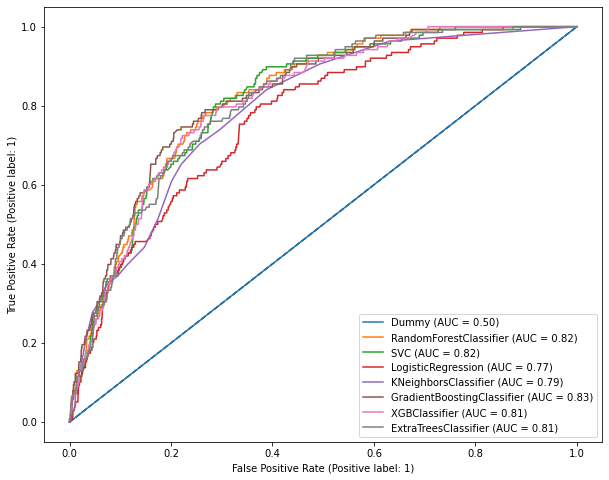

In [45]:
models = [dummy, rfc, svc, lr, knn, gbc, xgb, et]

fig, ax = plt.subplots(figsize=(10, 8))
plt.plot([0, 1], [0, 1], "k--")
for i, model in enumerate(models):
    RocCurveDisplay.from_estimator(
        model, X_val, y_val, ax=ax, name=f"{summary.index[i]}"
    )

From the graph, it can be observed that most of the models perform similarly in terms of ROC-AUC, except for Logistic Regression (red curve) being significantly worse and K Nearest Neighbors (purple curve) being slightly worse.

As there is a large class imbalance in our training data, ROC curve might present a overly optimistic view of the model's performance. Precision-Recall curve plot could be a better indicator on model's performance. From the Precision Recall AUC score, Gradient Boosting Classifier (0.21) and Random Forest Classifier (0.20) have the 2 highest scores. Both models performance is far from perfect score of 1 but performed better compared to the baseline score of 0.05.

## Precision-Recall Curve plot

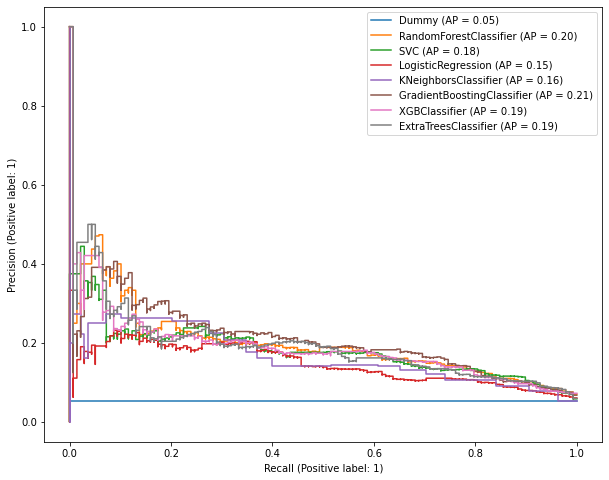

In [53]:
models = [dummy, rfc, svc, lr, knn, gbc, xgb, et]

fig, ax = plt.subplots(figsize=(10, 8))
for i, model in enumerate(models):
    PrecisionRecallDisplay.from_estimator(
        model, X_val, y_val, ax=ax, name=f"{summary.index[i]}"
    )
plt.legend(loc='upper right')

From the graph above, it can be observed that the precision drops quickly to less than 0.5 once recall is no longer 0. This means that amongst all predicted as positives, more than half are actually false alarms and WNV is actually not present.

If we aim for higher recall of 0.6-0.8 (correctly prediction 60-80% of WNV true positives), for most of the models except Logistic Regression (red curve), the precision drops to around 0.2, implying that around 4 in 5 positive predictions are false alarms. This is a trade-off that is necessary for our model to be useful in catching the areas where the virus may appear.

## Important features

In [54]:
def get_impt_features(models):
    result = pd.DataFrame()
    for i, model in enumerate(models):
        try:
            importances = model.best_estimator_.feature_importances_
            df = (
                pd.DataFrame(
                    zip(X_train.columns, importances),
                    columns=[f"{summary.index[i]}", "importance"],
                )
                .sort_values("importance", ascending=False)
                .reset_index(drop=True)
            )
            result = pd.concat([result, df], axis=1)

        except:
            pass

        try:
            coef = model.best_estimator_.coef_
            df = (
                pd.DataFrame([X_train.columns, (*coef)])
                .T.rename(columns={0: f"{summary.index[i]}", 1: "coefficient"})
                .sort_values("coefficient", ascending=False, key=abs)
                .reset_index(drop=True)
            )
            result = pd.concat([result, df], axis=1)

        except:
            pass

    return result

In [55]:
get_impt_features(models)

,RandomForestClassifier,importance,LogisticRegression,coefficient,GradientBoostingClassifier,importance,XGBClassifier,importance,ExtraTreesClassifier,importance
0,daylight,0.130022,dewpoint,4.337617,longitude,0.212056,tavg_weekly_lag1,0.110388,longitude,0.164932
1,longitude,0.107634,species_TERRITANS,-3.959661,daylight,0.199823,daylight,0.086401,latitude,0.131379
2,tavg_weekly_lag1,0.088004,species_SALINARIUS,-3.196961,latitude,0.113669,relative_hum_weekly_lag2,0.062645,daylight,0.065507
3,latitude,0.083411,wetbulb,-3.019824,tavg_weekly_lag1,0.059110,wetbulb,0.059319,tavg_weekly_lag1,0.050393
4,tavg_weekly_lag2,0.075317,cool,-2.247931,temp_fluct,0.045789,relative_hum_weekly_lag1,0.056001,species_PIPIENS,0.046159
5,tavg,0.053403,tavg,-2.048473,tmin,0.042682,longitude,0.050417,tavg_weekly_lag2,0.042012
6,cool,0.039705,tmin,2.018279,relative_hum_weekly,0.034392,species_PIPIENS,0.047678,relative_hum_weekly,0.036359
7,preciptotal_weekly_lag1,0.035699,tmax,1.913486,species_PIPIENS,0.029557,depart,0.047139,relative_hum_weekly_lag1,0.036108
8,tmax,0.034116,species_PIPIENS,1.802235,relative_hum,0.027580,tavg,0.045311,species_RESTUANS,0.036084
9,wetbulb,0.032553,species_ERRATICUS,-1.522391,tavg_weekly_lag2,0.026898,tmin,0.043876,relative_hum_weekly_lag2,0.030214


The selected model, Random Forest Classifier, predicted that these are the most important features;
- Daylight
- Longitude & Latitude
- Average and Lagged temperature

Location (operationalized by longitude and latitude) is not surprising considering the fact that infected mosquitoes tend to cluster at certain locations.

Light intensity (operationalized by daylight hours) is one of the features identified during EDA. However, what was unexpected was that average and lagged temperature are more predictive of WNV presence as compared precipitation and relative humidity. For a more in depth interpretation of meterological features on WNV presence, it is best to consult a biologist specializing in WNV and other infectious diseases that are transmitted by mosquitoes.

# Generating Predictions for Kaggle

For our final production model, it scored 0.72 on the kaggle training data.

![kaggle](../assets/kaggle_submission.png)

In [56]:
# import test dataset and final weather data
test = pd.read_csv("../input_data/test.csv")
weather = pd.read_csv("../output_data/weather_final.csv")

# check test dataframe
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      116293 non-null  int64  
 1   Date                    116293 non-null  object 
 2   Address                 116293 non-null  object 
 3   Species                 116293 non-null  object 
 4   Block                   116293 non-null  int64  
 5   Street                  116293 non-null  object 
 6   Trap                    116293 non-null  object 
 7   AddressNumberAndStreet  116293 non-null  object 
 8   Latitude                116293 non-null  float64
 9   Longitude               116293 non-null  float64
 10  AddressAccuracy         116293 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 9.8+ MB


In [57]:
# drop unnecessary columns
test.drop(
    columns=[
        "Address",
        "Block",
        "Street",
        "Trap",
        "AddressNumberAndStreet",
        "AddressAccuracy",
    ],
    inplace=True,
)

# rename columns to lowercase
test.columns = test.columns.str.lower()

# rename Species to drop 'CULEX'
test["species"] = [i[6:] for i in test["species"]]

# check dataframe
test.head()

,id,date,species,latitude,longitude
0,1,2008-06-11,PIPIENS/RESTUANS,41.95469,-87.800991
1,2,2008-06-11,RESTUANS,41.95469,-87.800991
2,3,2008-06-11,PIPIENS,41.95469,-87.800991
3,4,2008-06-11,SALINARIUS,41.95469,-87.800991
4,5,2008-06-11,TERRITANS,41.95469,-87.800991


In [58]:
# check weather dataframe
weather.head()

,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,preciptotal,...,relative_hum,tavg_weekly,relative_hum_weekly,preciptotal_weekly,tavg_weekly_lag1,tavg_weekly_lag2,relative_hum_weekly_lag1,relative_hum_weekly_lag2,preciptotal_weekly_lag1,preciptotal_weekly_lag2
0,2007-05-01,83.5,51.0,67.50,14.0,51.0,56.5,0.0,2.5,0.0,...,0.554538,56.910714,0.594914,0.09369,60.833333,60.7,0.621687,0.622469,0.226667,0.15
1,2007-05-02,59.5,42.5,51.50,-3.0,42.0,47.0,13.5,0.0,0.0,...,0.698858,56.910714,0.594914,0.09369,60.833333,60.7,0.621687,0.622469,0.226667,0.15
2,2007-05-03,66.5,47.0,57.00,2.0,40.0,49.0,8.0,0.0,0.0,...,0.529395,56.910714,0.594914,0.09369,60.833333,60.7,0.621687,0.622469,0.226667,0.15
3,2007-05-04,72.0,50.0,61.25,4.0,41.5,50.0,7.0,0.0,0.0,...,0.484224,56.910714,0.594914,0.09369,60.833333,60.7,0.621687,0.622469,0.226667,0.15
4,2007-05-05,66.0,53.5,60.00,5.0,38.5,49.5,5.0,0.0,0.0,...,0.448141,56.910714,0.594914,0.09369,60.833333,60.7,0.621687,0.622469,0.226667,0.15


In [59]:
# merge test with weather
test = test.merge(weather, on="date", how="left")
test.head()

,id,date,species,latitude,longitude,tmax,tmin,tavg,depart,dewpoint,...,relative_hum,tavg_weekly,relative_hum_weekly,preciptotal_weekly,tavg_weekly_lag1,tavg_weekly_lag2,relative_hum_weekly_lag1,relative_hum_weekly_lag2,preciptotal_weekly_lag1,preciptotal_weekly_lag2
0,1,2008-06-11,PIPIENS/RESTUANS,41.95469,-87.800991,86.0,63.5,75.0,7.0,55.5,...,0.507584,71.026786,0.607337,0.131607,67.3125,67.946429,0.608548,0.628498,0.149464,0.180982
1,2,2008-06-11,RESTUANS,41.95469,-87.800991,86.0,63.5,75.0,7.0,55.5,...,0.507584,71.026786,0.607337,0.131607,67.3125,67.946429,0.608548,0.628498,0.149464,0.180982
2,3,2008-06-11,PIPIENS,41.95469,-87.800991,86.0,63.5,75.0,7.0,55.5,...,0.507584,71.026786,0.607337,0.131607,67.3125,67.946429,0.608548,0.628498,0.149464,0.180982
3,4,2008-06-11,SALINARIUS,41.95469,-87.800991,86.0,63.5,75.0,7.0,55.5,...,0.507584,71.026786,0.607337,0.131607,67.3125,67.946429,0.608548,0.628498,0.149464,0.180982
4,5,2008-06-11,TERRITANS,41.95469,-87.800991,86.0,63.5,75.0,7.0,55.5,...,0.507584,71.026786,0.607337,0.131607,67.3125,67.946429,0.608548,0.628498,0.149464,0.180982


In [60]:
# transform feature matrix
X = pd.DataFrame(
    ct.transform(test.drop(columns=["id", "date"])),
    columns=ct.get_feature_names_out(),
)

In [61]:
X.columns

Index(['latitude', 'longitude', 'tmax', 'tmin', 'tavg', 'depart', 'dewpoint',
       'wetbulb', 'heat', 'cool', 'preciptotal', 'temp_fluct', 'daylight',
       'relative_hum', 'tavg_weekly', 'relative_hum_weekly',
       'preciptotal_weekly', 'tavg_weekly_lag1', 'tavg_weekly_lag2',
       'relative_hum_weekly_lag1', 'relative_hum_weekly_lag2',
       'preciptotal_weekly_lag1', 'preciptotal_weekly_lag2',
       'species_ERRATICUS', 'species_IFIED CULEX', 'species_PIPIENS',
       'species_PIPIENS/RESTUANS', 'species_RESTUANS', 'species_SALINARIUS',
       'species_TARSALIS', 'species_TERRITANS'],
      dtype='object')

In [63]:
# get predictions in csv format
def get_predictions(model):
    df = pd.DataFrame([test.id, model.predict_proba(X)[:, 1]]).T
    df.rename(columns={"Unnamed 0": "WnvPresent", "id": "Id"}, inplace=True)
    df.Id = df.Id.astype(int)
    return df

get_predictions(rfc).to_csv("../output_data/submit_rfc.csv", index=False)
# get_predictions(svc).to_csv("../output_data/submit_svc.csv", index=False)
# get_predictions(lr).to_csv("../output_data/submit_lr.csv", index=False)
# get_predictions(knn).to_csv("../output_data/submit_knn.csv", index=False)
# get_predictions(gbc).to_csv("../output_data/submit_gbc.csv", index=False)
# get_predictions(xgb).to_csv("../output_data/submit_xgb.csv", index=False)
# get_predictions(et).to_csv("../output_data/submit_et.csv", index=False)